# Calculate location colours
The colours for locations are calcuated and stored as a YAML file.

## Imports

In [1]:
from ag3 import release_data
ag3_data = release_data()

In [2]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import allel

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.colors as colors

## Settings

In [5]:
# https://matplotlib.org/examples/color/colormaps_reference.html
colour_map = 'nipy_spectral' 

output_path = '../data/location_colours.yml'

## Show the specified colour map

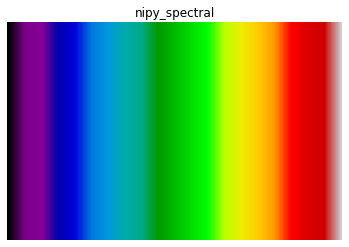

In [6]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.set_title(colour_map)
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(colour_map))
ax.set_axis_off()
plt.show()

## Get the locations of all of the wild samples

In [7]:
wild_sample_meta = ag3_data.load_sample_set_metadata(ag3_data.all_wild_sample_sets)
wild_sample_meta.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


partner_sample_id contributor country location  year  month  \
sample_id                                                               
AR0047-C             LUA047  Joao Pinto  Angola   Luanda  2009      4   
AR0049-C             LUA049  Joao Pinto  Angola   Luanda  2009      4   
AR0051-C             LUA051  Joao Pinto  Angola   Luanda  2009      4   
AR0061-C             LUA061  Joao Pinto  Angola   Luanda  2009      4   
AR0078-C             LUA078  Joao Pinto  Angola   Luanda  2009      4   

           latitude  longitude sex_call  sample_set  aim_fraction_colu  \
sample_id                                                                
AR0047-C     -8.884     13.302        F  AG1000G-AO              0.945   
AR0049-C     -8.884     13.302        F  AG1000G-AO              0.933   
AR0051-C     -8.884     13.302        F  AG1000G-AO              0.937   
AR0061-C     -8.884     13.302        F  AG1000G-AO              0.938   
AR0078-C     -8.884     13.302        F  AG1000G-AO              0.926   

           aim_fraction_arab species_gambcolu_arabiensis  \
sample_id                                                  
AR0047-C               0.001                   gamb_colu   
AR0049-C               0.001                   gamb_colu   
AR0051-C               0.002                   gamb_colu   
AR0061-C               0.002                   gamb_colu   
AR0078-C               0.001                   gamb_colu   

          species_gambiae_coluzzii  is_arabiensis  is_gamb_colu  is_gambiae  \
sample_id                                                                     
AR0047-C                  coluzzii          False          True       False   
AR0049-C                  coluzzii          False          True       False   
AR0051-C                  coluzzii          False          True       False   
AR0061-C                  coluzzii          False          True       False   
AR0078-C                  coluzzii          False          True       False   

           is_coluzzii  
sample_id               
AR0047-C          True  
AR0049-C          True  
AR0051-C          True  
AR0061-C          True  
AR0078-C          True

In [8]:
# We only need the unique locations
locations = wild_sample_meta[['country', 'location', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
locations

country        location  latitude  longitude
0          Angola          Luanda    -8.884     13.302
1    Burkina Faso            Pala    11.150     -4.235
2    Burkina Faso            Bana    11.233     -4.472
3    Burkina Faso  Souroukoudinga    11.235     -4.535
4    Burkina Faso      Monomtenga    12.060     -1.170
..            ...             ...       ...        ...
121      Tanzania           Moshi    -3.482     37.308
122      Tanzania          Tarime    -1.431     34.199
123      Tanzania          Muheza    -4.940     38.948
124        Uganda       Nagongera     0.770     34.026
125        Uganda          Kihihi    -0.751     29.701

[126 rows x 4 columns]

## Calculate the location colours

In [9]:
# Define a function to reduce all of the lat-longs (2D) to a single dimension (values 0 to 1) using PCA. 
def reduce_geographical_dimensionality(latitudes, longitudes):
    
    # TODO: add comments to explain these steps
    
    X_features = np.hstack([latitudes.reshape((-1, 1)), longitudes.reshape((-1, 1))])
    assert X_features.shape[1] == 2

    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)

    pca = PCA()
    pca.fit_transform(X_features)
    pca_variance = pca.explained_variance_

    coordinates = pca.transform(X_features)
    xv = coordinates[:, 0]
    yv = coordinates[:, 1]
    
    xv_for_map_col = (xv - xv.min())/(xv.max() - xv.min())
    return xv_for_map_col

In [10]:
locations["xv"] = reduce_geographical_dimensionality(locations.latitude.values, locations.longitude.values)
locations

country        location  latitude  longitude        xv
0          Angola          Luanda    -8.884     13.302  0.589528
1    Burkina Faso            Pala    11.150     -4.235  0.130406
2    Burkina Faso            Bana    11.233     -4.472  0.127217
3    Burkina Faso  Souroukoudinga    11.235     -4.535  0.126692
4    Burkina Faso      Monomtenga    12.060     -1.170  0.139783
..            ...             ...       ...        ...       ...
121      Tanzania           Moshi    -3.482     37.308  0.690685
122      Tanzania          Tarime    -1.431     34.199  0.633398
123      Tanzania          Muheza    -4.940     38.948  0.726946
124        Uganda       Nagongera     0.770     34.026  0.596687
125        Uganda          Kihihi    -0.751     29.701  0.587261

[126 rows x 5 columns]

## Check the location colours on a map

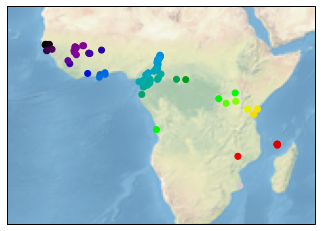

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

xlim = ([locations["longitude"].min() - 10,  locations["longitude"].max() + 10])
ylim = ([locations["latitude"].min() - 10,  locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.scatter(locations["longitude"], locations["latitude"], c=locations["xv"], cmap=colour_map)

plt.show()

## Record the RGBA tuple for each xv for this colour map

In [12]:
locations["RGBA_tuple"] = locations["xv"].apply(cm.get_cmap(colour_map))
locations["RGBA_tuple"][0]

(0.0, 0.968635294117647, 0.0, 1.0)

## Convert the RGBA tuple to hexadecimal for storage

In [13]:
locations["RGBA_hex"] = locations["RGBA_tuple"].apply(colors.to_hex, keep_alpha=True)
locations["RGBA_hex"][0]

'#00f700ff'

## Store the location colours as a file

In [14]:
# Get the location_labels and their corresponding RGBA cmap colours
location_colours = locations[['country', 'location', 'RGBA_hex']].set_index(['country', 'location'])
location_colours

RGBA_hex
country      location                 
Angola       Luanda          #00f700ff
Burkina Faso Pala            #3800a3ff
             Bana            #4300a2ff
             Souroukoudinga  #4300a2ff
             Monomtenga      #2300a6ff
...                                ...
Tanzania     Moshi           #e4f100ff
             Tarime          #84ff00ff
             Muheza          #f8da00ff
Uganda       Nagongera       #00fc00ff
             Kihihi          #00f700ff

[126 rows x 1 columns]

### Convert the DataFrame values into a dictionary

In [15]:
# Note: Panda's to_dict(orient='index') converts multi-column index into a tuple,
# which isn't what we want for the YAML
#location_colours_as_dict = location_colours.to_dict(orient='index')
#list(location_colours_as_dict.keys())[0]
#ignore_index=True

In [16]:
# Compose the dict manually
location_colours_as_dict = {}
for country, country_group in location_colours.groupby('country'):
    location_colours_as_dict[country] = {}
    for location, location_group in country_group.groupby('location'):
        location_colours_as_dict[country][location] = location_group['RGBA_hex'][0]

In [17]:
location_colours_as_dict.keys()

dict_keys(['Angola', 'Burkina Faso', 'Cameroon', 'Central African Republic', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mayotte', 'Mozambique', 'Tanzania', 'Uganda'])

In [18]:
location_colours_as_dict['Burkina Faso']

{'Bana': '#4300a2ff',
 'Monomtenga': '#2300a6ff',
 'Pala': '#3800a3ff',
 'Souroukoudinga': '#4300a2ff'}

In [19]:
# Write the dictionary to YAML
with open(output_path, 'w') as ymlfile:
    yaml.dump(location_colours_as_dict, ymlfile, sort_keys=True)

## Check the location colours file

In [20]:
# Load the data from the YAML file
with open(output_path) as file:
    reloaded_data_dict = yaml.load(file, Loader=yaml.Loader)

In [21]:
reloaded_data_dict.keys()

dict_keys(['Angola', 'Burkina Faso', 'Cameroon', 'Central African Republic', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mayotte', 'Mozambique', 'Tanzania', 'Uganda'])

In [22]:
reloaded_data_dict['Burkina Faso']

{'Bana': '#4300a2ff',
 'Monomtenga': '#2300a6ff',
 'Pala': '#3800a3ff',
 'Souroukoudinga': '#4300a2ff'}

### Convert the dict into a DataFrame

In [23]:
# Note: Panda's from_dict() and from_records() don't interpret the dict in the way we want
#reloaded_df = pd.DataFrame.from_dict(reloaded_data_dict)
#reloaded_df.head()

In [24]:
# Compose the DataFrame manually
reloaded_df = pd.DataFrame(columns=['country', 'location', 'RGBA_hex'])
for country in reloaded_data_dict.keys():
    for location in reloaded_data_dict[country].keys():
        reloaded_df = reloaded_df.append(
            {'country': country, 'location': location, 'RGBA_hex': reloaded_data_dict[country][location]},
            ignore_index=True
        )
reloaded_df

country        location   RGBA_hex
0          Angola          Luanda  #00f700ff
1    Burkina Faso            Bana  #4300a2ff
2    Burkina Faso      Monomtenga  #2300a6ff
3    Burkina Faso            Pala  #3800a3ff
4    Burkina Faso  Souroukoudinga  #4300a2ff
..            ...             ...        ...
121      Tanzania          Muheza  #f8da00ff
122      Tanzania          Muleba  #58ff00ff
123      Tanzania          Tarime  #84ff00ff
124        Uganda          Kihihi  #00f700ff
125        Uganda       Nagongera  #00fc00ff

[126 rows x 3 columns]

In [25]:
# Match the location labels with the lat longs we have
original_locations = locations[['country', 'location', 'longitude', 'latitude']]
recovered_locations = reloaded_df.merge(original_locations, on=['country', 'location'])
recovered_locations

country        location   RGBA_hex  longitude  latitude
0          Angola          Luanda  #00f700ff     13.302    -8.884
1    Burkina Faso            Bana  #4300a2ff     -4.472    11.233
2    Burkina Faso      Monomtenga  #2300a6ff     -1.170    12.060
3    Burkina Faso            Pala  #3800a3ff     -4.235    11.150
4    Burkina Faso  Souroukoudinga  #4300a2ff     -4.535    11.235
..            ...             ...        ...        ...       ...
121      Tanzania          Muheza  #f8da00ff     38.948    -4.940
122      Tanzania          Muleba  #58ff00ff     31.651    -1.962
123      Tanzania          Tarime  #84ff00ff     34.199    -1.431
124        Uganda          Kihihi  #00f700ff     29.701    -0.751
125        Uganda       Nagongera  #00fc00ff     34.026     0.770

[126 rows x 5 columns]

### Eyeball the colours from the file on a map

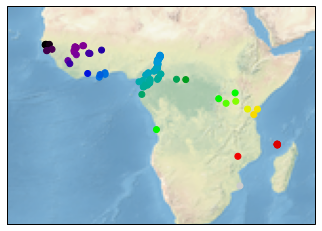

In [26]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

xlim = ([recovered_locations["longitude"].min() - 10,  recovered_locations["longitude"].max() + 10])
ylim = ([recovered_locations["latitude"].min() - 10,  recovered_locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.scatter(recovered_locations["longitude"], recovered_locations["latitude"], color=recovered_locations["RGBA_hex"])

plt.show()